# load Albatros data for DAS analysis


Requires: xarray, gsw 
Can be installed with conda on conda-forge channel

In [1]:
from glob import glob

import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

import gsw

In [10]:
root_dir = "emso_ligure/"

def load_emso_nc(file, resample=None):

    ds = xr.open_dataset(file)
    ds = (ds
          .assign_coords(row=ds.time)
          .drop("time")
          .rename(row="time")
          .sortby("time")
         )

    dt = (ds.time.diff("time")/pd.Timedelta("1m")).median() # in minutes
    print(f"Median sampling interval = {float(dt)} minutes")

    # should despike prior to resampling (in principle) ...
    # resample
    if resample:
        ds = ds.resample(time=resample).mean()
    
    return ds

In [14]:
microcat_nc = root_dir+"Emso_Ligure_Ouest_MII_Microcat_CSV_6272_aac2_400c.nc"

ds_microcat = load_emso_nc(microcat_nc, resample="20min")

ds_microcat

Median sampling interval = 3.05 minutes


<xarray.Dataset>
Dimensions:      (time: 39591)
Coordinates:
  * time         (time) datetime64[ns] 2019-07-01T03:00:00 ... 2020-12-31T23:...
Data variables:
    Temperature  (time) float32 13.3 13.3 13.3 13.3 13.3 ... 13.3 13.3 13.3 13.3

In [15]:
aquadop_nc = root_dir+"Emso_Ligure_Ouest_MII_Aquadopp_NetCDF_3bc5_e3b3_b8d8.nc"

reload = False

if reload:
    ds_aqua = xr.open_dataset(aquadop_nc)
else:
    ds_aqua = load_emso_nc(aquadop_nc, resample=None) #"20min"
    ds_aqua.to_netcdf(root_dir+"aquadop.nc")
    
ds_aqua

Median sampling interval = 3.0 minutes


<xarray.Dataset>
Dimensions:      (time: 414580)
Coordinates:
  * time         (time) datetime64[ns] 2019-05-23T19:10:40 ... 2022-02-17T12:...
Data variables: (12/19)
    stationname  (time) object ...
    latitude     (time) float32 ...
    longitude    (time) float32 ...
    depth        (time) float32 ...
    X_East       (time) float32 ...
    Y_North      (time) float32 ...
    ...           ...
    Pitch        (time) float32 ...
    Roll         (time) float32 ...
    Pressure     (time) float32 ...
    TIS          (time) float32 ...
    Speed        (time) float32 ...
    Direction    (time) float32 ...
Attributes: (12/48)
    cdm_data_type:                 TimeSeries
    cdm_timeseries_variables:      stationname,latitude,longitude
    comment:                       Scientific objectives at Ligurian site htt...
    contact:                       Dominique Lefevre (dominique.lefevre@mio.o...
    contributor_name:              maurice.libes@osupytheas.fr
    contributor_role:              raw data conversion, and data formating in...
    ...                            ...
    summary:                       EMSO Ligure Ouest (Network Common Data For...
    testOutOfDate:                 now-1day
    time_coverage_end:             2022-02-17T12:28:03Z
    time_coverage_start:           2019-05-23T19:10:40Z
    title:                         EMSO Ligure Ouest : MII capteur AQUADOPP (...
    Westernmost_Easting:           6.029

In [61]:
_temp = ds_microcat["Temperature"]
_u = ds_aqua["X_East"]
_v = ds_aqua["Y_North"]
_w = ds_aqua["Z_up"]

---

## time series

Get sense of periods covered and order of amplitudes

Text(0.5, 1.0, 'Albatros microcat')

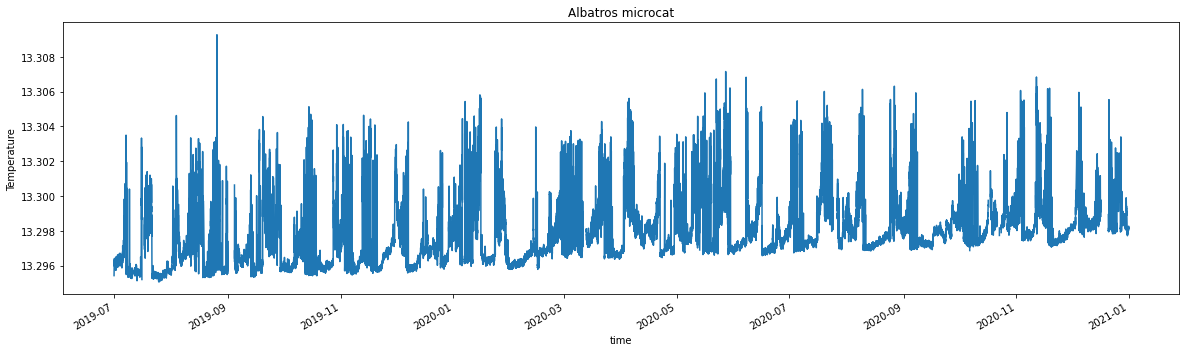

In [44]:
fig, ax = plt.subplots(1,1, figsize=(20,5))
_temp.plot()
ax.set_title("Albatros microcat")

Text(0.5, 1.0, 'Albatros aquadopp')

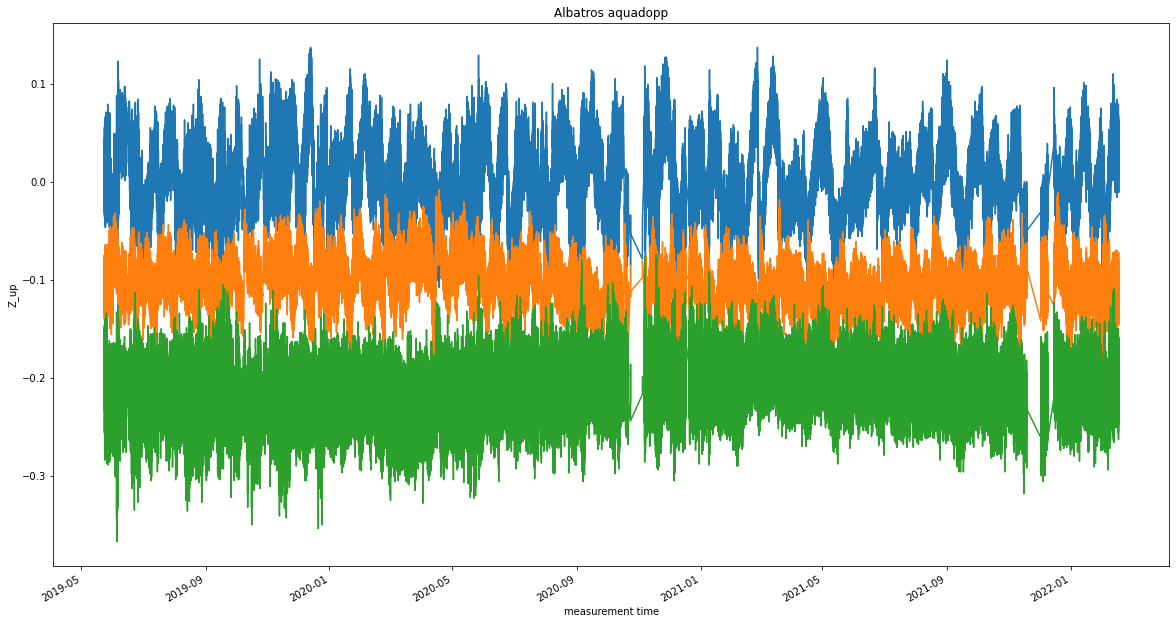

In [62]:
fig, ax = plt.subplots(1,1, figsize=(20,10))
_u.plot()
(_v-.1).plot()
(_w-.2).plot()

ax.set_title("Albatros aquadopp")

### Weekly averaged data

Mild warming trend: $2 \; 10^{-3}$degC / year

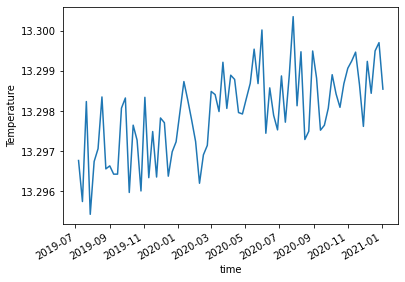

In [47]:
_temp.resample(time="1W").mean().plot()

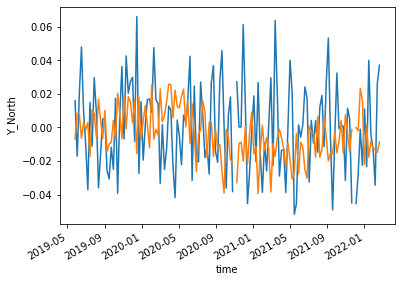

In [48]:
_u.resample(time="1W").mean().plot()
_v.resample(time="1W").mean().plot()

### Annual composite

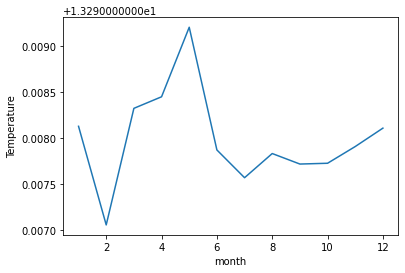

In [49]:
_temp.groupby("time.month").mean().plot()

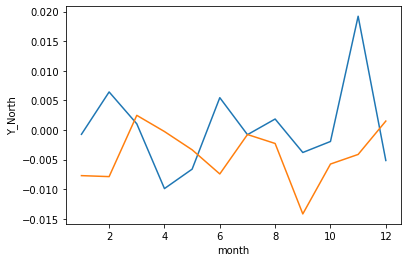

In [50]:
_u.groupby("time.month").mean().plot()
_v.groupby("time.month").mean().plot()

--- 

## zoom July 2019

In [63]:
def plot_tempuv(time):
    fig, axes = plt.subplots(4,1, figsize=(20,20))
    ax = axes[0]
    _temp.sel(time=time).plot(ax=ax)
    ax = axes[1]
    _u.sel(time=time).plot(ax=ax)
    ax = axes[2]
    _v.sel(time=time).plot(ax=ax)
    ax = axes[3]
    _w.sel(time=time).plot(ax=ax)    

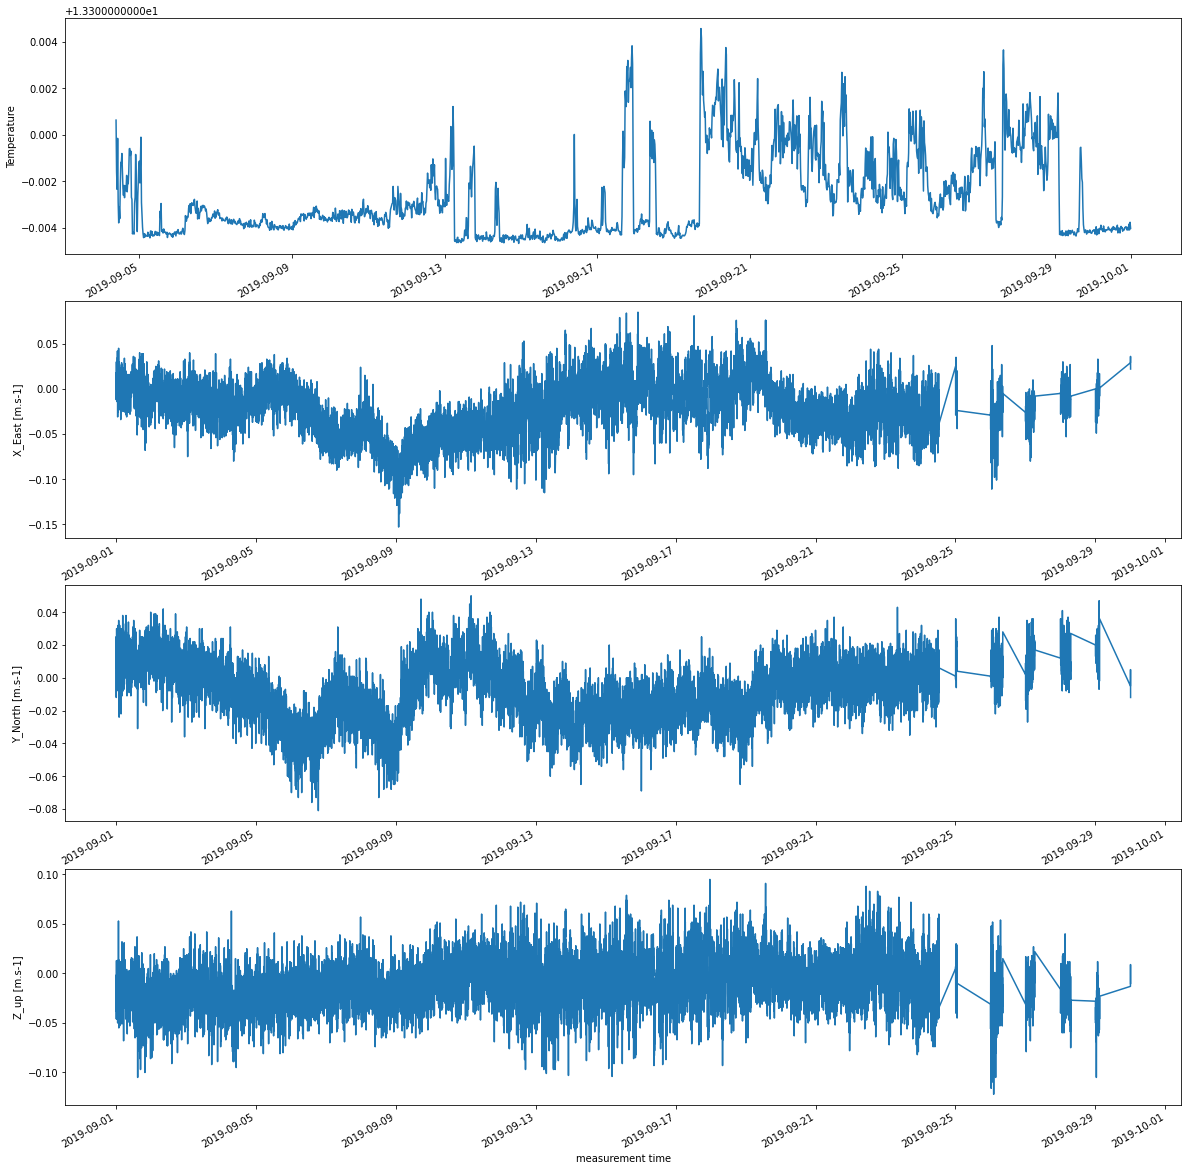

In [64]:
plot_tempuv("2019-09")

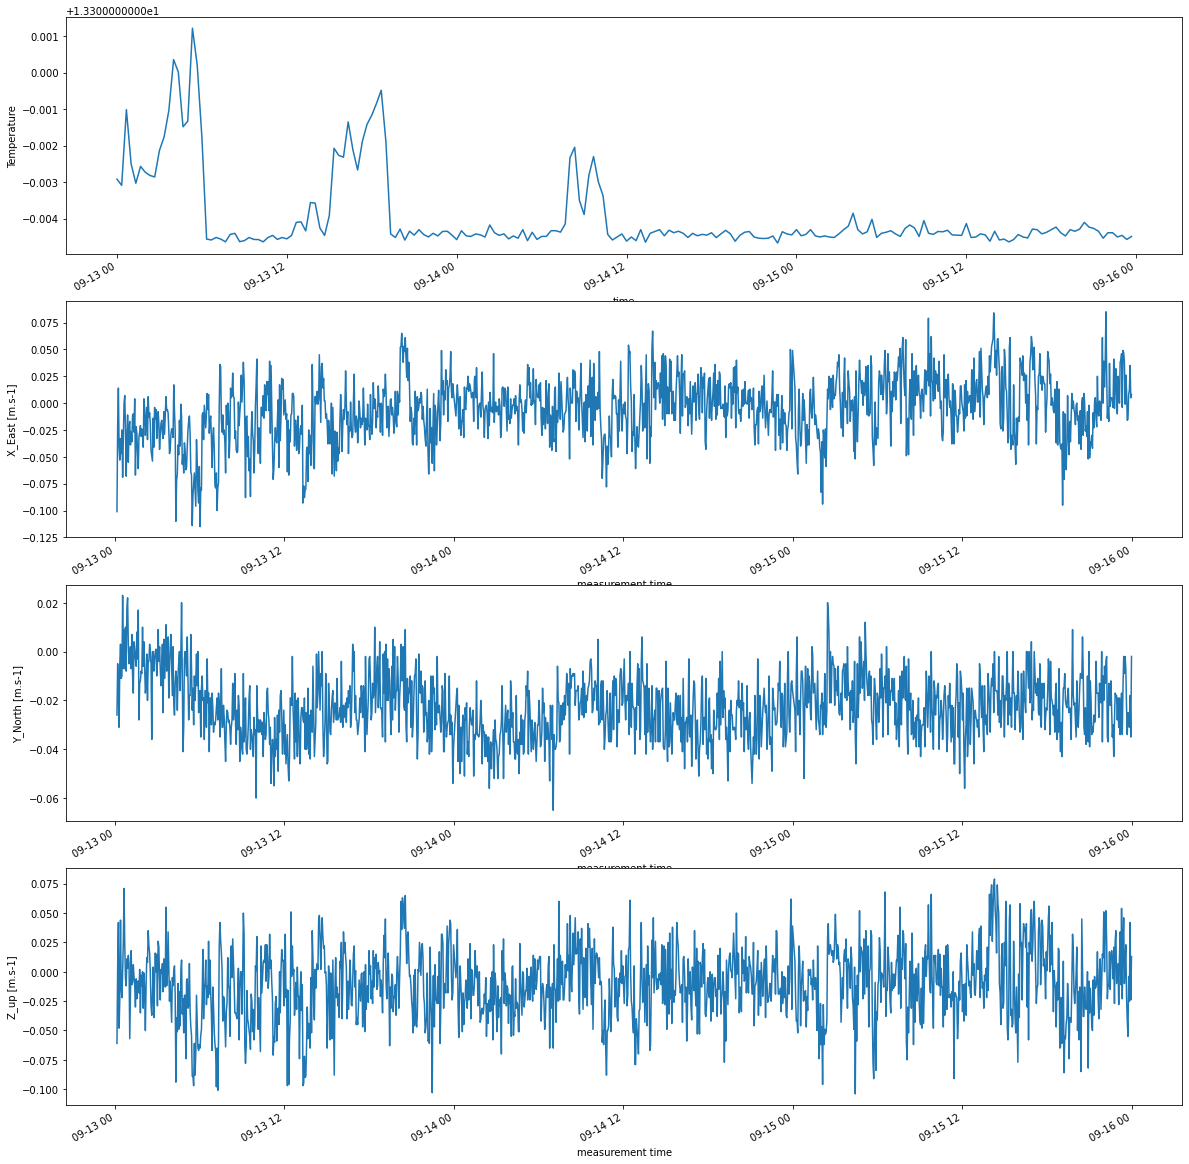

In [65]:
plot_tempuv(slice("2019-09-13", "2019-09-15"))

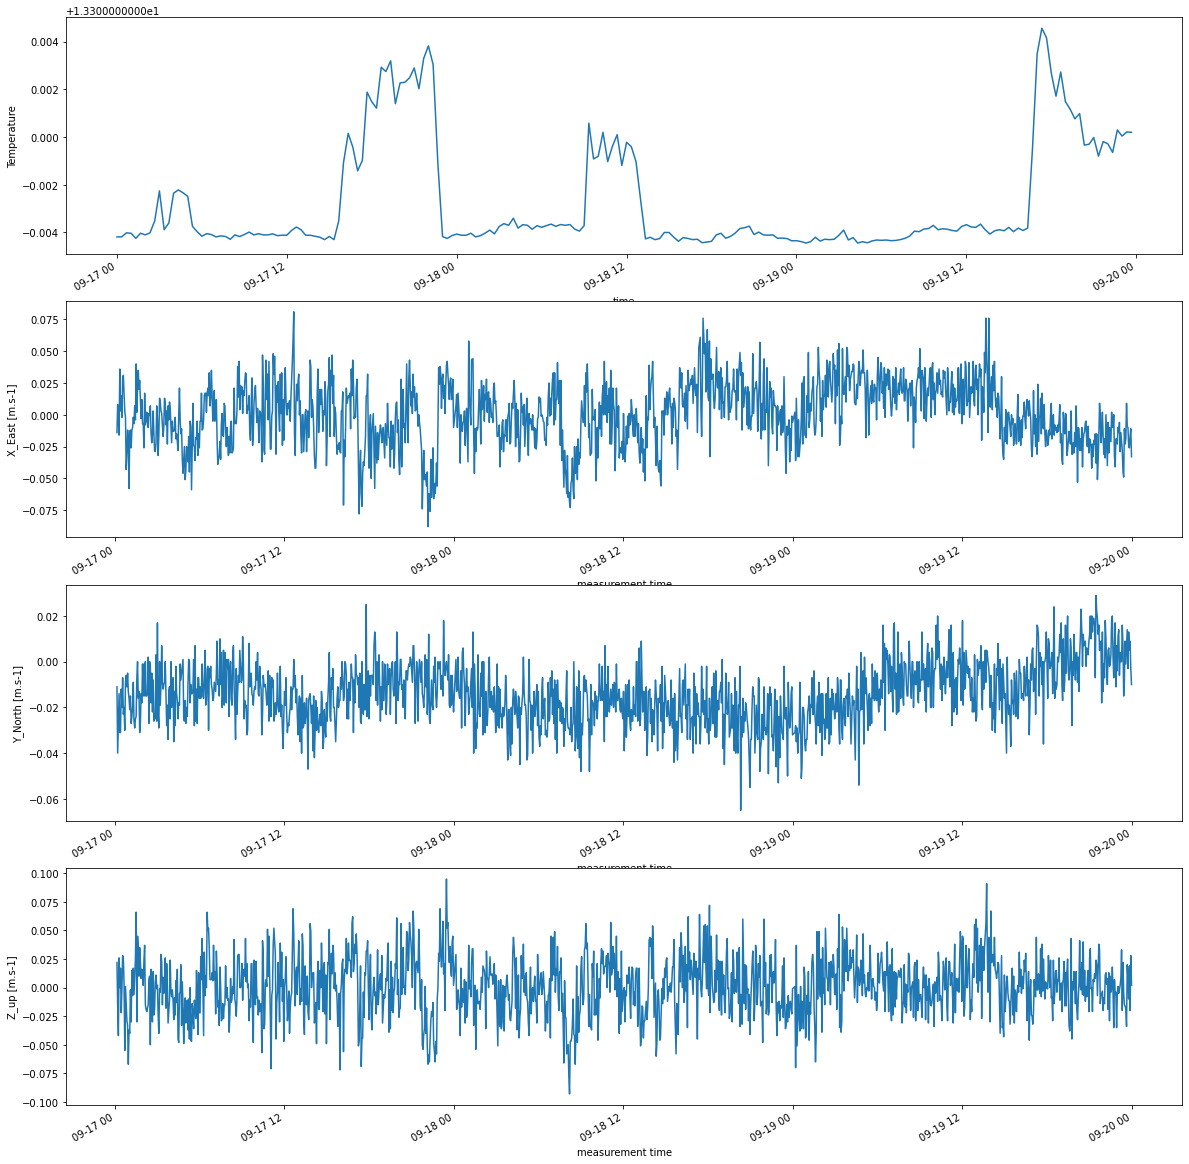

In [66]:
plot_tempuv(slice("2019-09-17","2019-09-19"))

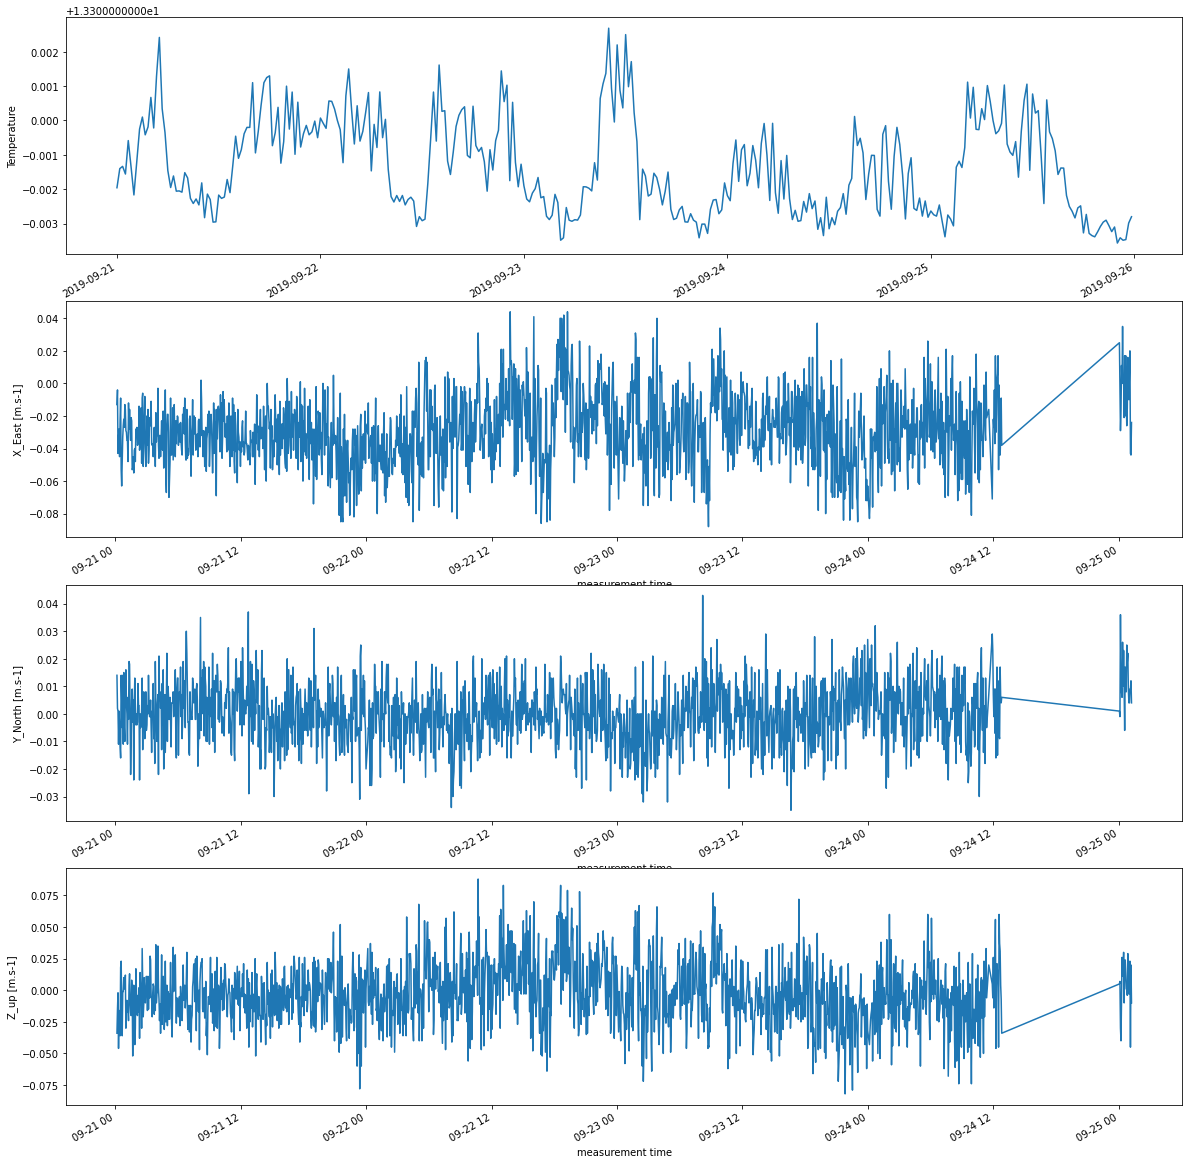

In [67]:
plot_tempuv(slice("2019-09-21","2019-09-25"))

---

## zoom on octobre 2020

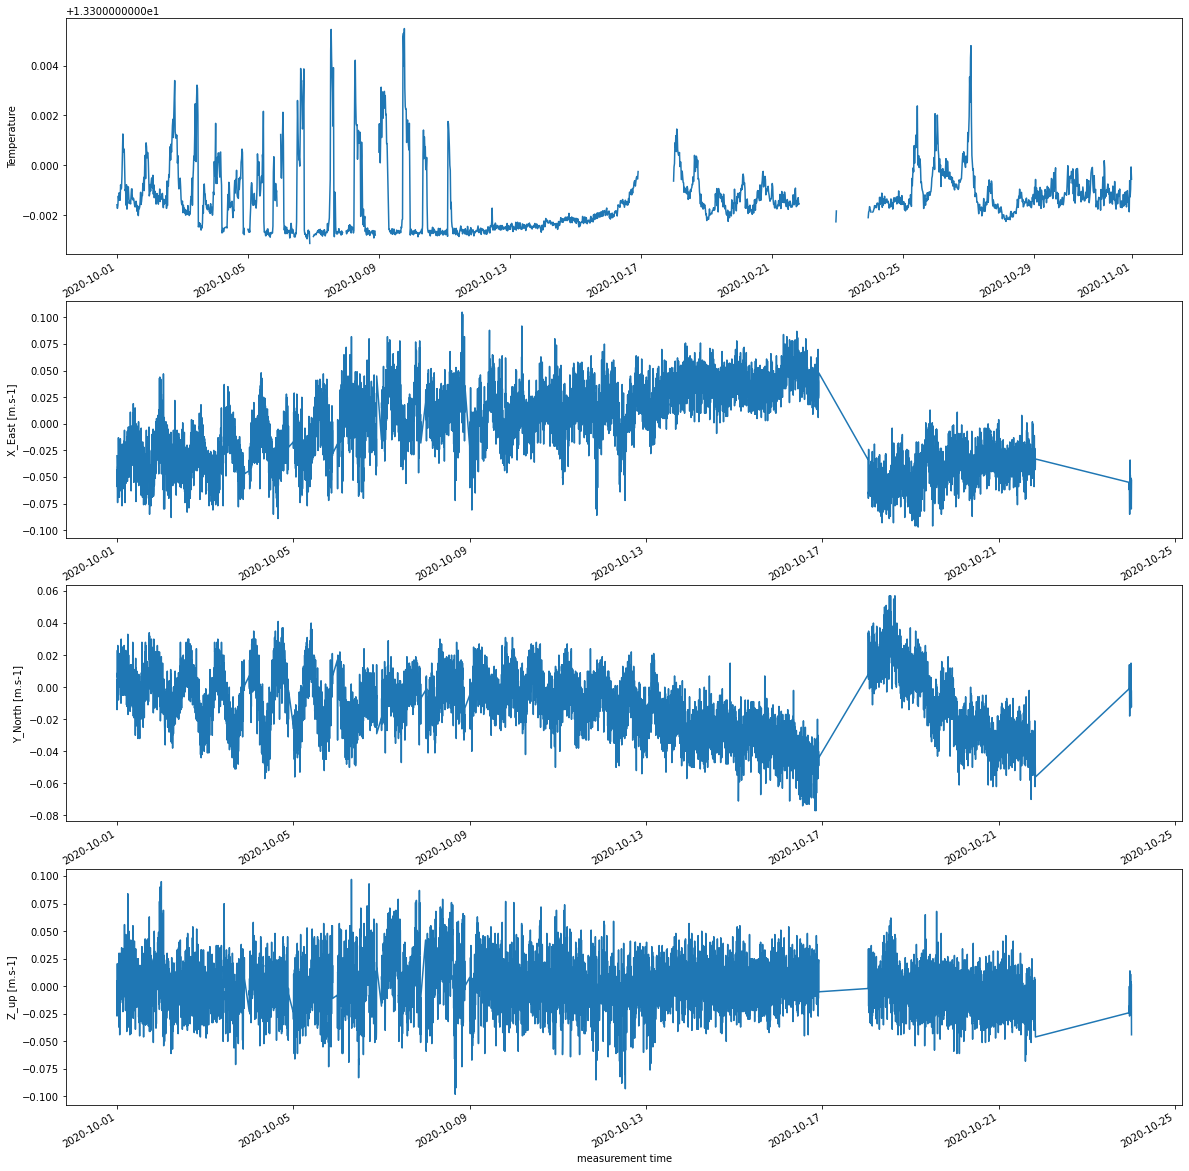

In [68]:
plot_tempuv("2020-10")

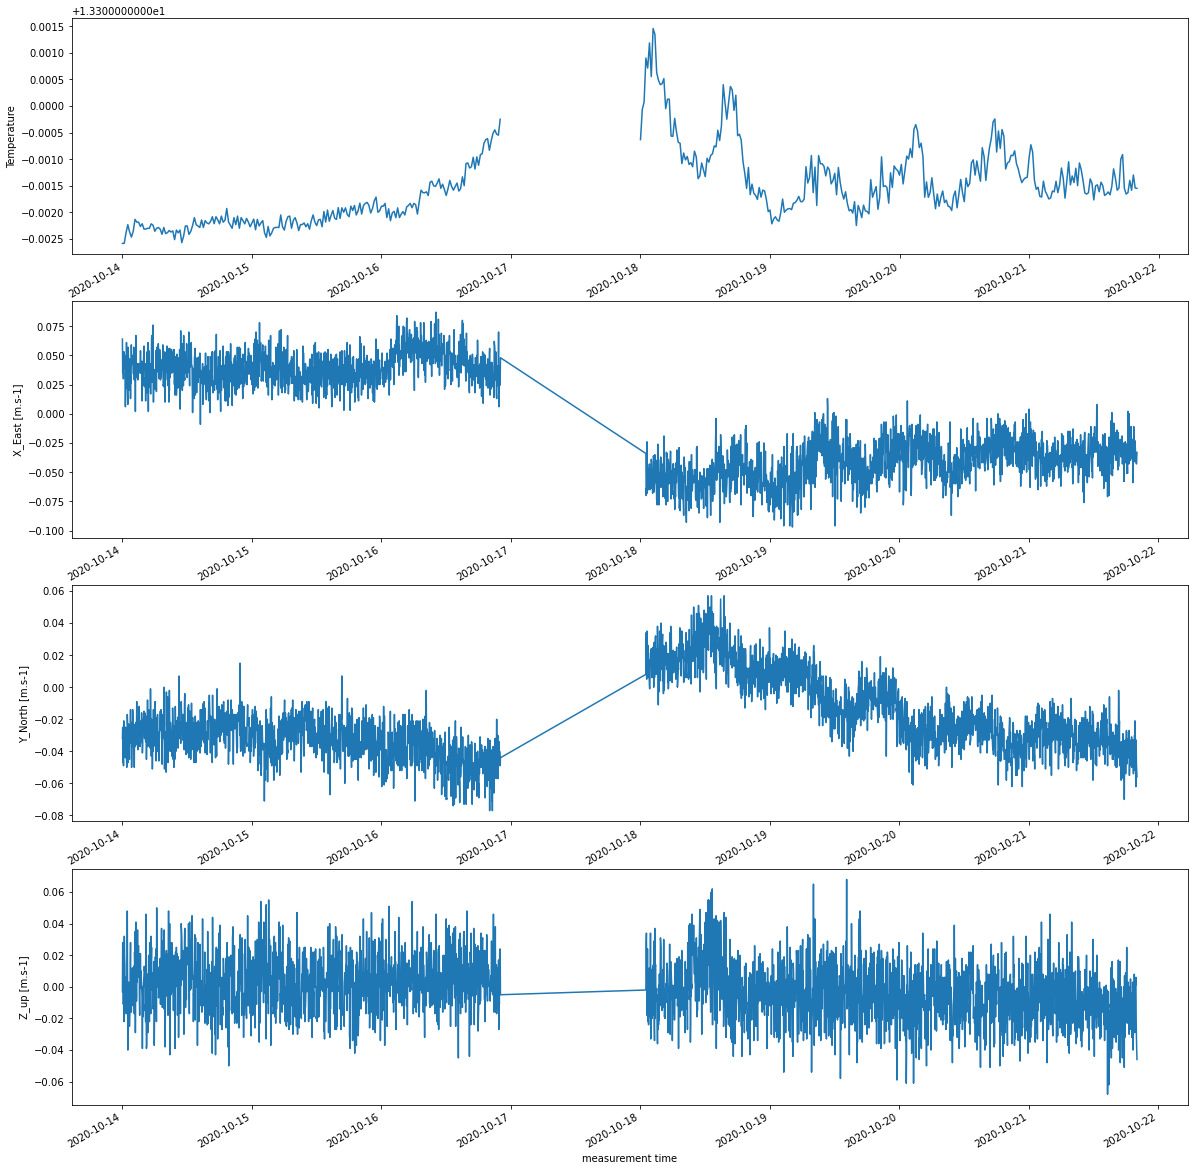

In [69]:
plot_tempuv(slice("2020-10-14","2020-10-21"))

---

## inspect autocorrelation


In [70]:
import sstats.sigp as sigp

In [79]:
def autocorrelation(x):    
    da = x - x.mean()
    da = da.fillna(0)
    da = da.assign_coords(time=(da.time - da.time[0])/pd.Timedelta("1H"))
    c = sigp.correlate(da, da).compute()
    return c

In [75]:
_ur = _u.resample(time="20min").mean()
_vr = _v.resample(time="20min").mean()
_wr = _w.resample(time="20min").mean()

In [80]:
temp_c = autocorrelation(_temp)

u_c = autocorrelation(_ur)
v_c = autocorrelation(_vr)
w_c = autocorrelation(_wr)

Full autocorrelation:

In [81]:
u_c

<xarray.DataArray 'X_East_X_East' (lags: 72053)>
array([ 1.04141611e-03,  9.96952942e-04,  9.84965814e-04, ...,
       -6.29663491e-09, -9.27843913e-09, -7.04243222e-09])
Coordinates:
  * lags     (lags) float64 0.0 0.3333 0.6667 ... 2.402e+04 2.402e+04 2.402e+04

Text(0.5, 0, 'lags [hours]')

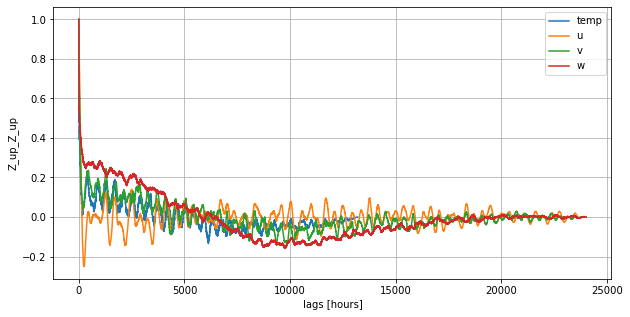

In [82]:
fig, ax = plt.subplots(1, 1, figsize=(10,5))
(temp_c/temp_c.sel(lags=0)).plot(label="temp")
(u_c/u_c.sel(lags=0)).plot(label="u")
(v_c/v_c.sel(lags=0)).plot(label="v")
(w_c/w_c.sel(lags=0)).plot(label="w")

ax.grid()
ax.legend()
ax.set_xlabel("lags [hours]")

Text(0.5, 0, 'lags [hours]')

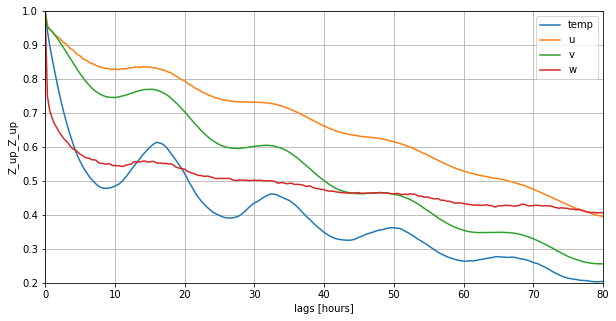

In [108]:
fig, ax = plt.subplots(1, 1, figsize=(10,5))
(temp_c/temp_c.sel(lags=0)).plot(label="temp")
(u_c/u_c.sel(lags=0)).plot(label="u")
(v_c/v_c.sel(lags=0)).plot(label="v")
(w_c/w_c.sel(lags=0)).plot(label="w")

ax.set_xlim(0,80)
ax.set_ylim(0.2, 1.)
ax.grid()
ax.legend()
ax.set_xlabel("lags [hours]")

In [99]:
def spectrum(x):
    da = x - x.mean()
    da = da.fillna(0)    
    da = da.assign_coords(time=(da.time-da.time[0])/pd.Timedelta("1D"))
    E, f = sigp.spectrum_welch(da, return_onesided=True)
    return E, f

In [102]:
E_temp, f = spectrum(_temp)
E_u, f = spectrum(_ur)
E_v, f = spectrum(_vr)
E_w, f = spectrum(_wr)

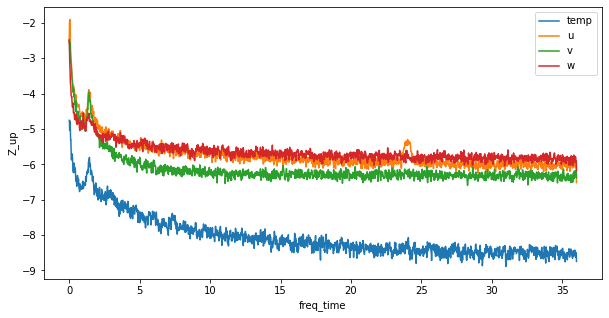

In [105]:
fig, ax = plt.subplots(1, 1, figsize=(10,5))
np.log10(E_temp).plot(label="temp")
np.log10(E_u).plot(label="u")
np.log10(E_v).plot(label="v")
np.log10(E_w).plot(label="w")
ax.legend()

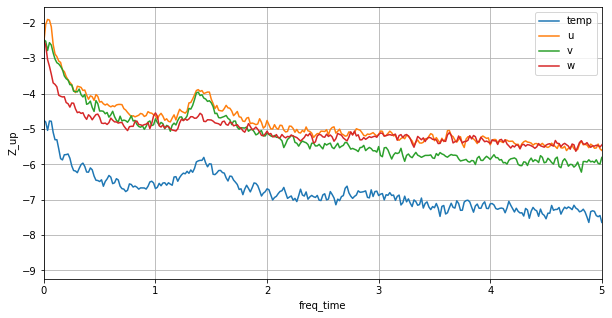

In [106]:
fig, ax = plt.subplots(1, 1, figsize=(10,5))
np.log10(E_temp).plot(label="temp")
np.log10(E_u).plot(label="u")
np.log10(E_v).plot(label="v")
np.log10(E_w).plot(label="w")
ax.legend()
ax.set_xlim(0,5)
ax.grid()

In [4]:
import numpy as np
import matplotlib.pyplot as plt

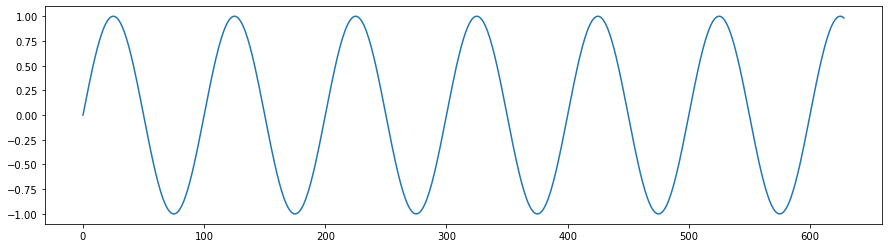

In [11]:
t = np.arange(0,2*np.pi*1,.01)
x = np.sin(2*np.pi*t)

fig, ax = plt.subplots(1,1, figsize=(15,4))
plt.plot(x)